In [1]:
# Imports

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Images

In [3]:
# Load book image
book_img = cv2.imread('/kaggle/input/asg-2-1-data/cv_cover.jpg')
book_img = cv2.cvtColor(book_img, cv2.COLOR_BGR2RGB)

# Load first frame of book.mov
cap = cv2.VideoCapture('/kaggle/input/asg-2-1-data/book.mov')
ret, frame = cap.read()
if ret:
    video_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cap.release()

# SIFT Detector

In [4]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(book_img, None) # No mask
kp2, des2 = sift.detectAndCompute(video_frame, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2) # For each feature in img, we get best 2 matches in video

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m) # Make sure matches are valid

selected_matches = good_matches[:50] # Get 50 best matches

# Plot Results

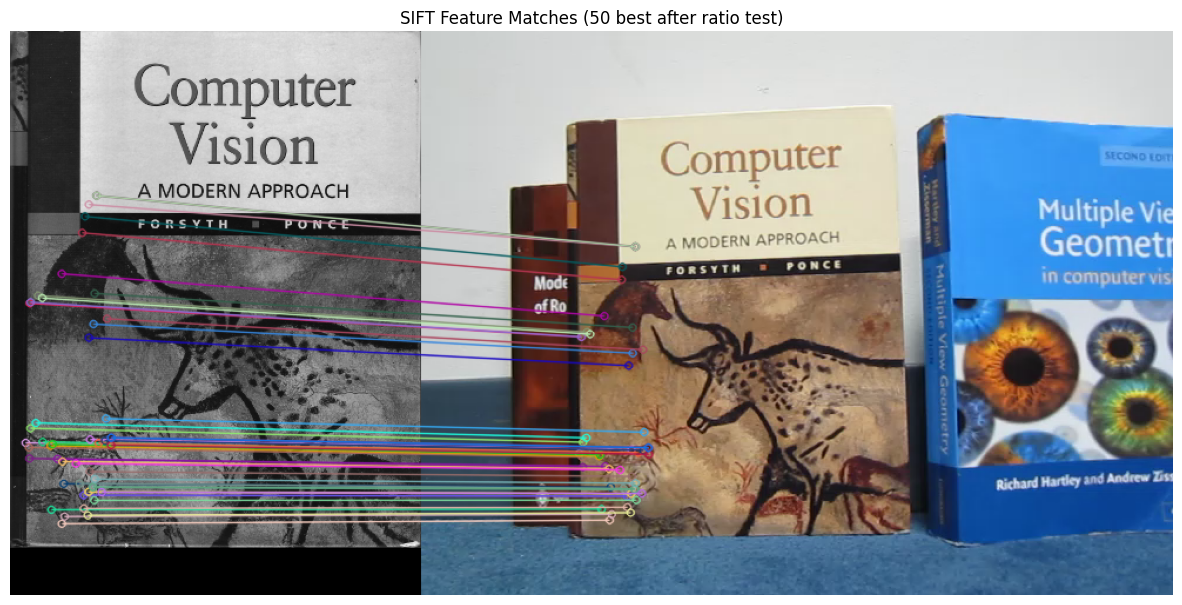

In [5]:
matched_img = cv2.drawMatches(
    book_img, kp1, video_frame, kp2, selected_matches, None, flags=2
)

plt.figure(figsize=(15, 10))
plt.imshow(matched_img)
plt.axis('off')
plt.title("SIFT Feature Matches (50 best after ratio test)")
plt.show()

# Finding Homogenous Matrix

In [6]:
def extract_matched_points(kp1, kp2, matches):
    """
    Extract source and destination points from matches
    """
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches])
    return src_pts, dst_pts

# Extract points from our selected matches
src_points, dst_points = extract_matched_points(kp1, kp2, selected_matches)

In [7]:
def compute_homography(src_points, dst_points):
    assert len(src_points) >= 4, "Need at least 4 point pairs"
    assert len(src_points) == len(dst_points), "Point lists must have same length"
    
    n = len(src_points)
    A = np.zeros((2*n, 9))
    
    for i in range(n):
        x, y = src_points[i]
        xp, yp = dst_points[i]
        
        # First equation for this point pair
        A[2*i] = [-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp]
        # Second equation for this point pair
        A[2*i+1] = [0, 0, 0, -x, -y, -1, x*yp, y*yp, yp]
    
    # Solve using SVD
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    
    # Normalize so that H[2,2] = 1
    H = H / H[2, 2]
    
    return H

In [8]:
def apply_homography(points, H):
    """
    Apply homography to points
    """
    points_homogeneous = np.column_stack([points, np.ones(len(points))])
    transformed = H @ points_homogeneous.T
    transformed = transformed / transformed[2]  # normalize
    return transformed[:2].T

In [9]:
def compute_homography_ransac(src_points, dst_points, max_iters=1000, threshold=5.0):
    """
    Compute homography using RANSAC for robust estimation.
    
    Parameters:
    src_points: source points
    dst_points: destination points  
    max_iters: maximum RANSAC iterations
    threshold: inlier threshold in pixels
    
    Returns:
    H: best homography matrix
    inliers: boolean mask of inliers
    """
    assert len(src_points) >= 4, "Need at least 4 point pairs"
    
    n_points = len(src_points)
    best_H = None
    best_inliers = None
    max_inliers = 0
    
    for i in range(max_iters):
        # Randomly select 4 point pairs
        indices = np.random.choice(n_points, 4, replace=False)
        src_sample = src_points[indices]
        dst_sample = dst_points[indices]
        
        try:
            # Compute homography from minimal sample
            H = compute_homography(src_sample, dst_sample)
            
            # Transform all source points
            transformed = apply_homography(src_points, H)
            
            # Compute errors
            errors = np.linalg.norm(transformed - dst_points, axis=1)
            
            # Count inliers
            inliers = errors < threshold
            n_inliers = np.sum(inliers)
            
            if n_inliers > max_inliers:
                max_inliers = n_inliers
                best_H = H
                best_inliers = inliers
                
        except np.linalg.LinAlgError:
            # Skip if homography computation fails
            continue
    
    print(f"RANSAC found {max_inliers} inliers out of {n_points} points")
    
    # Recompute homography using all inliers for better accuracy
    if max_inliers >= 4:
        src_inliers = src_points[best_inliers]
        dst_inliers = dst_points[best_inliers]
        best_H = compute_homography(src_inliers, dst_inliers)
    
    return best_H, best_inliers

RANSAC found 49 inliers out of 50 points
Using 49 inlier matches


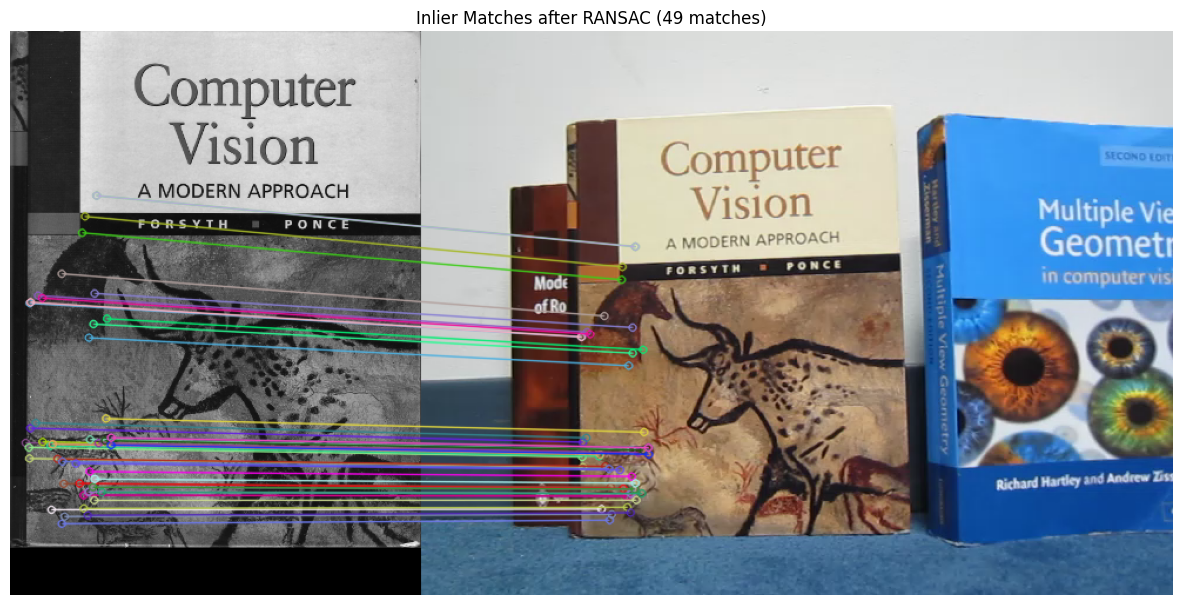

In [10]:
# Compute homography with RANSAC
H_ransac, inlier_mask = compute_homography_ransac(src_points, dst_points, max_iters=2000, threshold=3.0)

# Get inlier matches for visualization
inlier_matches = [selected_matches[i] for i in range(len(selected_matches)) if inlier_mask[i]]

print(f"Using {len(inlier_matches)} inlier matches")

# Visualize inlier matches
inlier_matched_img = cv2.drawMatches(
    book_img, kp1, video_frame, kp2, inlier_matches, None, flags=2
)

plt.figure(figsize=(15, 8))
plt.imshow(inlier_matched_img)
plt.title(f"Inlier Matches after RANSAC ({len(inlier_matches)} matches)")
plt.axis('off')
plt.show()

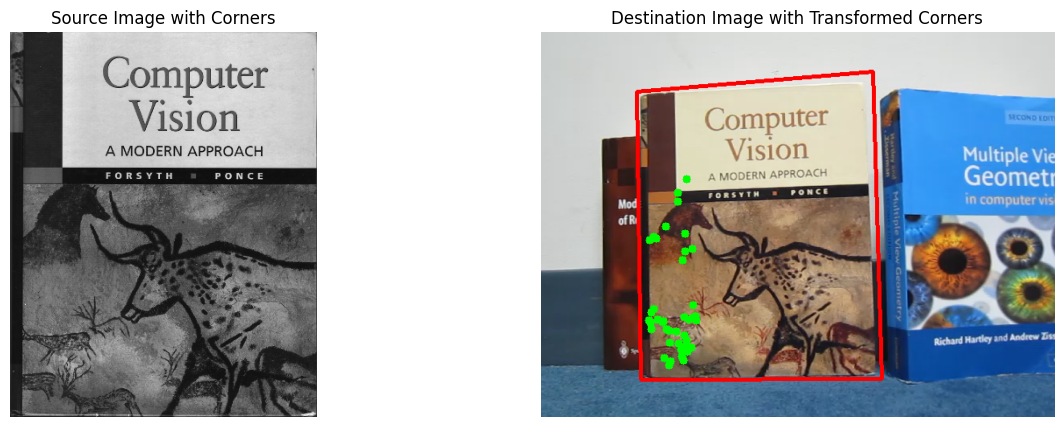

In [11]:
def visualize_homography(src_img, dst_img, src_points, dst_points, H):
    """
    Visualize homography by transforming source corners to destination
    """
    # Transform source image corners
    h, w = src_img.shape[:2]
    corners = np.float32([[0,0], [w,0], [w,h], [0,h]]).reshape(-1,1,2)
    transformed_corners = cv2.perspectiveTransform(corners, H)
    
    # Draw on destination image
    result_img = dst_img.copy()
    cv2.polylines(result_img, [np.int32(transformed_corners)], True, (255, 0, 0), 3)
    
    # Also draw actual matched points
    for pt in dst_points:
        cv2.circle(result_img, tuple(pt.astype(int)), 5, (0, 255, 0), -1)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(src_img)
    plt.title("Source Image with Corners")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(result_img)
    plt.title("Destination Image with Transformed Corners")
    plt.axis('off')
    plt.show()
    
    return transformed_corners

# Visualize
transformed_corners = visualize_homography(book_img, video_frame, src_points, dst_points, H_ransac)

# Find Image Corners

In [12]:
def get_book_corners(book_img):
    """
    Get the four corners of the book cover in the source image
    """
    h, w = book_img.shape[:2]
    
    # The four corners: top-left, top-right, bottom-right, bottom-left
    corners_src = np.float32([
        [0, 0],      # top-left
        [w, 0],      # top-right  
        [w, h],      # bottom-right
        [0, h]       # bottom-left
    ])
    
    return corners_src

# Get source corners
corners_src = get_book_corners(book_img)
print("Source book corners (pixels):")
for i, corner in enumerate(corners_src):
    print(f"Corner {i}: ({corner[0]:.1f}, {corner[1]:.1f})")

Source book corners (pixels):
Corner 0: (0.0, 0.0)
Corner 1: (350.0, 0.0)
Corner 2: (350.0, 440.0)
Corner 3: (0.0, 440.0)


In [13]:
def transform_book_corners(corners_src, H):
    """
    Transform book corners from source image to video frame using homography
    """
    # Reshape for perspectiveTransform
    corners_src_reshaped = corners_src.reshape(-1, 1, 2)
    
    # Apply homography
    corners_dst = cv2.perspectiveTransform(corners_src_reshaped, H)
    
    return corners_dst.reshape(-1, 2)

# Transform corners to video frame
corners_video = transform_book_corners(corners_src, H_ransac)
print("\nTransformed book corners in video frame (pixels):")
for i, corner in enumerate(corners_video):
    print(f"Corner {i}: ({corner[0]:.1f}, {corner[1]:.1f})")


Transformed book corners in video frame (pixels):
Corner 0: (119.5, 74.9)
Corner 1: (414.0, 49.1)
Corner 2: (424.8, 432.0)
Corner 3: (124.8, 433.9)


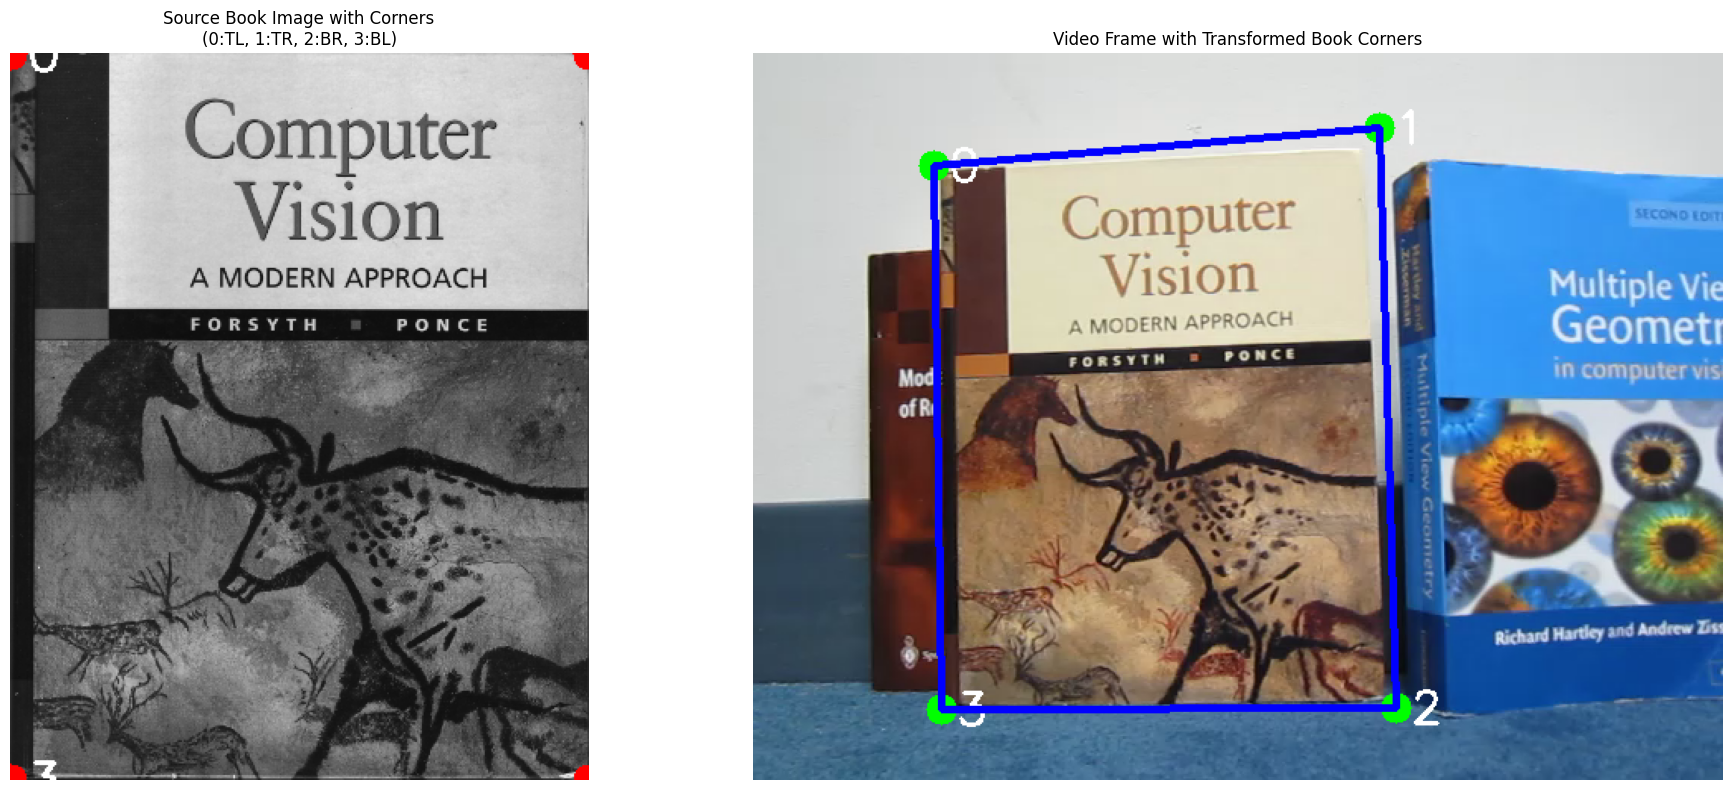

In [14]:
def visualize_book_corners(book_img, video_frame, corners_src, corners_video):
    """
    Visualize the book corners in both source and destination images
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Source image with corners
    src_with_corners = book_img.copy()
    for i, corner in enumerate(corners_src):
        x, y = corner
        cv2.circle(src_with_corners, (int(x), int(y)), 10, (255, 0, 0), -1)
        cv2.putText(src_with_corners, str(i), (int(x)+10, int(y)+10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    axes[0].imshow(src_with_corners)
    axes[0].set_title('Source Book Image with Corners\n(0:TL, 1:TR, 2:BR, 3:BL)')
    axes[0].axis('off')
    
    # Video frame with transformed corners
    video_with_corners = video_frame.copy()
    for i, corner in enumerate(corners_video):
        x, y = corner
        cv2.circle(video_with_corners, (int(x), int(y)), 10, (0, 255, 0), -1)
        cv2.putText(video_with_corners, str(i), (int(x)+10, int(y)+10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Draw the quadrilateral
    corners_int = np.int32(corners_video)
    cv2.polylines(video_with_corners, [corners_int], True, (0, 0, 255), 3)
    
    axes[1].imshow(video_with_corners)
    axes[1].set_title('Video Frame with Transformed Book Corners')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return video_with_corners

# Visualize the corners
result_img = visualize_book_corners(book_img, video_frame, corners_src, corners_video)

In [15]:
def calculate_book_dimensions(corners_video):
    """
    Calculate the width and height of the book in the video frame
    """
    # Calculate side lengths
    top_width = np.linalg.norm(corners_video[1] - corners_video[0])
    bottom_width = np.linalg.norm(corners_video[2] - corners_video[3])
    left_height = np.linalg.norm(corners_video[3] - corners_video[0])
    right_height = np.linalg.norm(corners_video[2] - corners_video[1])
    
    avg_width = (top_width + bottom_width) / 2
    avg_height = (left_height + right_height) / 2
    
    print(f"Book dimensions in video frame:")
    print(f"Average width: {avg_width:.2f} pixels")
    print(f"Average height: {avg_height:.2f} pixels")
    print(f"Aspect ratio: {avg_width/avg_height:.3f}")
    
    return avg_width, avg_height

book_width, book_height = calculate_book_dimensions(corners_video)

Book dimensions in video frame:
Average width: 297.77 pixels
Average height: 371.07 pixels
Aspect ratio: 0.802


# Crop AR Video Frames

In [16]:
def calculate_target_aspect_ratio(book_corners):
    """
    Calculate the aspect ratio of the book in the video frame
    """
    # Calculate width (average of top and bottom)
    top_width = np.linalg.norm(book_corners[1] - book_corners[0]) # Find euclidean dist
    bottom_width = np.linalg.norm(book_corners[2] - book_corners[3])
    avg_width = (top_width + bottom_width) / 2
    
    # Calculate height (average of left and right)
    left_height = np.linalg.norm(book_corners[3] - book_corners[0])
    right_height = np.linalg.norm(book_corners[2] - book_corners[1])
    avg_height = (left_height + right_height) / 2
    
    aspect_ratio = avg_width / avg_height
    
    print(f"Book aspect ratio: {aspect_ratio:.3f} (width: {avg_width:.1f}px / height: {avg_height:.1f}px)")
    return aspect_ratio, avg_width, avg_height

# Calculate target aspect ratio
target_aspect_ratio, target_width, target_height = calculate_target_aspect_ratio(corners_video)

Book aspect ratio: 0.802 (width: 297.8px / height: 371.1px)


In [17]:
def get_video_info(video_path):
    """
    Get video information and load first frame
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # cap.get returns float by default
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Read first frame
    ret, first_frame = cap.read()
    if not ret:
        raise ValueError("Could not read first frame from video")
    
    cap.release()
    
    video_info = {
        'fps': fps,
        'total_frames': total_frames,
        'width': width,
        'height': height,
        'first_frame': first_frame,
        'aspect_ratio': width / height
    }
    
    return video_info

# Load AR source video info
ar_video_info = get_video_info('/kaggle/input/asg-2-1-data/ar_source.mov')
print(f"AR Source Video: {ar_video_info['width']}x{ar_video_info['height']}, "
      f"FPS: {ar_video_info['fps']:.1f}, Frames: {ar_video_info['total_frames']}")
print(f"AR Source aspect ratio: {ar_video_info['aspect_ratio']:.3f}")

AR Source Video: 640x360, FPS: 25.0, Frames: 511
AR Source aspect ratio: 1.778


In [18]:
def calculate_crop_region(video_width, video_height, target_aspect_ratio):
    """
    Calculate the crop region to match target aspect ratio
    """
    current_aspect_ratio = video_width / video_height
    
    if current_aspect_ratio > target_aspect_ratio:
        # Video is wider than target - crop width
        new_width = int(target_aspect_ratio * video_height)
        crop_width = (video_width - new_width) // 2
        crop_region = (crop_width, 0, crop_width + new_width, video_height)
        crop_type = "sides"
    else:
        # Video is taller than target - crop height
        new_height = int(video_width / target_aspect_ratio)
        crop_height = (video_height - new_height) // 2
        crop_region = (0, crop_height, video_width, crop_height + new_height)
        crop_type = "top_bottom"
    
    print(f"Crop type: {crop_type}")
    print(f"Original: {video_width}x{video_height} (aspect: {current_aspect_ratio:.3f})")
    print(f"Cropped: {crop_region[2]-crop_region[0]}x{crop_region[3]-crop_region[1]} (aspect: {target_aspect_ratio:.3f})")
    
    return crop_region

# Calculate crop region for AR source video
crop_region = calculate_crop_region(
    ar_video_info['width'], 
    ar_video_info['height'], 
    target_aspect_ratio
)

Crop type: sides
Original: 640x360 (aspect: 1.778)
Cropped: 288x360 (aspect: 0.802)


In [19]:
def crop_frame(frame, crop_region):
    """
    Crop a single frame according to the crop region
    """
    x1, y1, x2, y2 = crop_region
    cropped_frame = frame[y1:y2, x1:x2]
    return cropped_frame

# Test cropping on first frame
first_frame_cropped = crop_frame(ar_video_info['first_frame'], crop_region)

print(f"Cropped frame shape: {first_frame_cropped.shape}")

Cropped frame shape: (360, 288, 3)


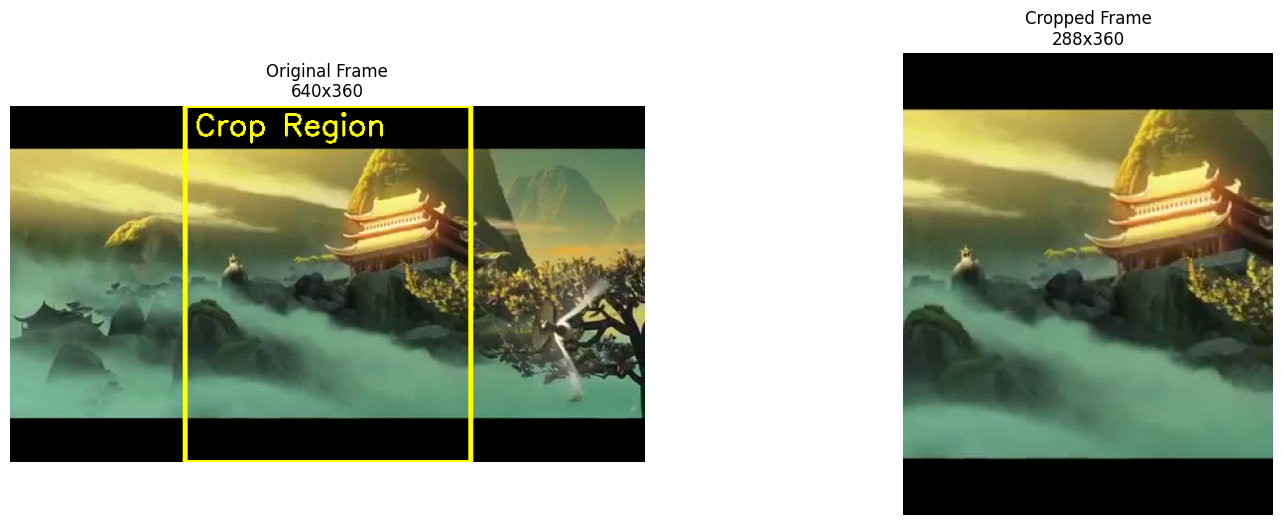

In [20]:
def visualize_cropping(original_frame, cropped_frame, crop_region):
    """
    Visualize the cropping process
    """
    # Create visualization with crop region marked
    vis_frame = original_frame.copy()
    x1, y1, x2, y2 = crop_region
    
    # Draw crop rectangle
    cv2.rectangle(vis_frame, (x1, y1), (x2, y2), (0, 255, 255), 3)
    cv2.putText(vis_frame, "Crop Region", (x1+10, y1+30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Original frame with crop region
    axes[0].imshow(cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Original Frame\n{original_frame.shape[1]}x{original_frame.shape[0]}')
    axes[0].axis('off')
    
    # Cropped frame
    axes[1].imshow(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Cropped Frame\n{cropped_frame.shape[1]}x{cropped_frame.shape[0]}')
    axes[1].axis('off')

# Visualize cropping
visualize_cropping(ar_video_info['first_frame'], first_frame_cropped, crop_region)

In [21]:
def crop_video_frames(video_path, crop_region, max_frames=None):
    """
    Crop all frames of a video according to crop region
    Returns a list of cropped frames
    """
    cap = cv2.VideoCapture(video_path)
    cropped_frames = []
    
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        if max_frames and frame_count >= max_frames:
            break
            
        # Crop frame
        cropped_frame = crop_frame(frame, crop_region)
        cropped_frames.append(cropped_frame)
        
        frame_count += 1
        if frame_count % 30 == 0:
            print(f"Processed {frame_count} frames...")
    
    cap.release()
    print(f"Finished cropping {len(cropped_frames)} frames")
    return cropped_frames

# Crop all frames (you might want to test with a few frames first)
print("Cropping AR source video frames...")
# Test with first 10 frames for speed
cropped_ar_frames = crop_video_frames('/kaggle/input/asg-2-1-data/ar_source.mov', crop_region, max_frames=10)
print(f"Successfully cropped {len(cropped_ar_frames)} frames")

Cropping AR source video frames...
Finished cropping 10 frames
Successfully cropped 10 frames


# Overlay Frames

In [22]:
def warp_frame_to_book(cropped_frame, book_corners_video):
    """
    Warp the cropped AR frame to fit the book's perspective in the video frame
    """
    # Get dimensions of cropped frame
    h_src, w_src = cropped_frame.shape[:2]
    
    # Define source points (the entire cropped frame)
    src_corners = np.float32([
        [0, 0],           # top-left
        [w_src, 0],       # top-right
        [w_src, h_src],   # bottom-right
        [0, h_src]        # bottom-left
    ])
    
    # Destination points are the book corners in the video frame
    dst_corners = book_corners_video
    
    # Calculate homography from cropped frame to book region
    H_warp, _ = cv2.findHomography(src_corners, dst_corners, cv2.RANSAC, 5.0)
    
    # Warp the cropped frame to book shape
    h_dst, w_dst = video_frame.shape[:2]
    warped_frame = cv2.warpPerspective(cropped_frame, H_warp, (w_dst, h_dst))
    
    return warped_frame, H_warp

# Warp the first cropped AR frame to book shape
first_cropped_ar_frame = cropped_ar_frames[0]
warped_ar_frame, H_warp = warp_frame_to_book(first_cropped_ar_frame, corners_video)

print(f"Original cropped frame shape: {first_cropped_ar_frame.shape}")
print(f"Warped frame shape: {warped_ar_frame.shape}")
print(f"Video frame shape: {video_frame.shape}")

Original cropped frame shape: (360, 288, 3)
Warped frame shape: (480, 640, 3)
Video frame shape: (480, 640, 3)


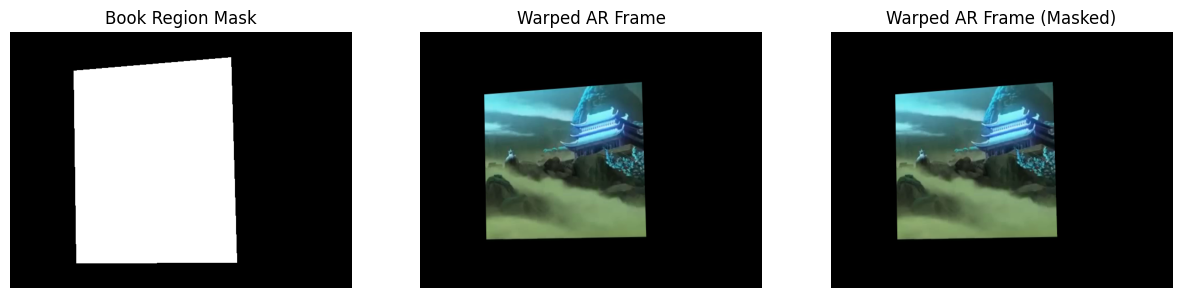

In [23]:
def create_book_mask(video_frame_shape, book_corners):
    """
    Create a mask for the book region in the video frame
    """
    mask = np.zeros(video_frame_shape[:2], dtype=np.uint8)
    
    # Fill the book quadrilateral with white
    cv2.fillConvexPoly(mask, np.int32(book_corners), 255)
    
    return mask

# Create mask for book region
book_mask = create_book_mask(video_frame.shape, corners_video)

# Visualize the mask
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(book_mask, cmap='gray')
plt.title('Book Region Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(warped_ar_frame)
plt.title('Warped AR Frame')
plt.axis('off')

plt.subplot(1, 3, 3)
masked_warped = cv2.bitwise_and(warped_ar_frame, warped_ar_frame, mask=book_mask)
plt.imshow(masked_warped)
plt.title('Warped AR Frame (Masked)')
plt.axis('off')
plt.show()

In [24]:
def overlay_ar_on_book(video_frame, warped_ar_frame, book_mask):
    """
    Overlay the warped AR frame onto the video frame using the book mask
    """
    # Create inverse mask for the original video
    inverse_mask = cv2.bitwise_not(book_mask)
    
    # Remove the book region from original video
    background = cv2.bitwise_and(video_frame, video_frame, mask=inverse_mask)
    
    # Combine with warped AR frame
    foreground = cv2.bitwise_and(warped_ar_frame, warped_ar_frame, mask=book_mask)
    
    # Final composite
    result = cv2.add(background, foreground)
    
    return result

# Create the AR overlay
ar_result = overlay_ar_on_book(video_frame, warped_ar_frame, book_mask)

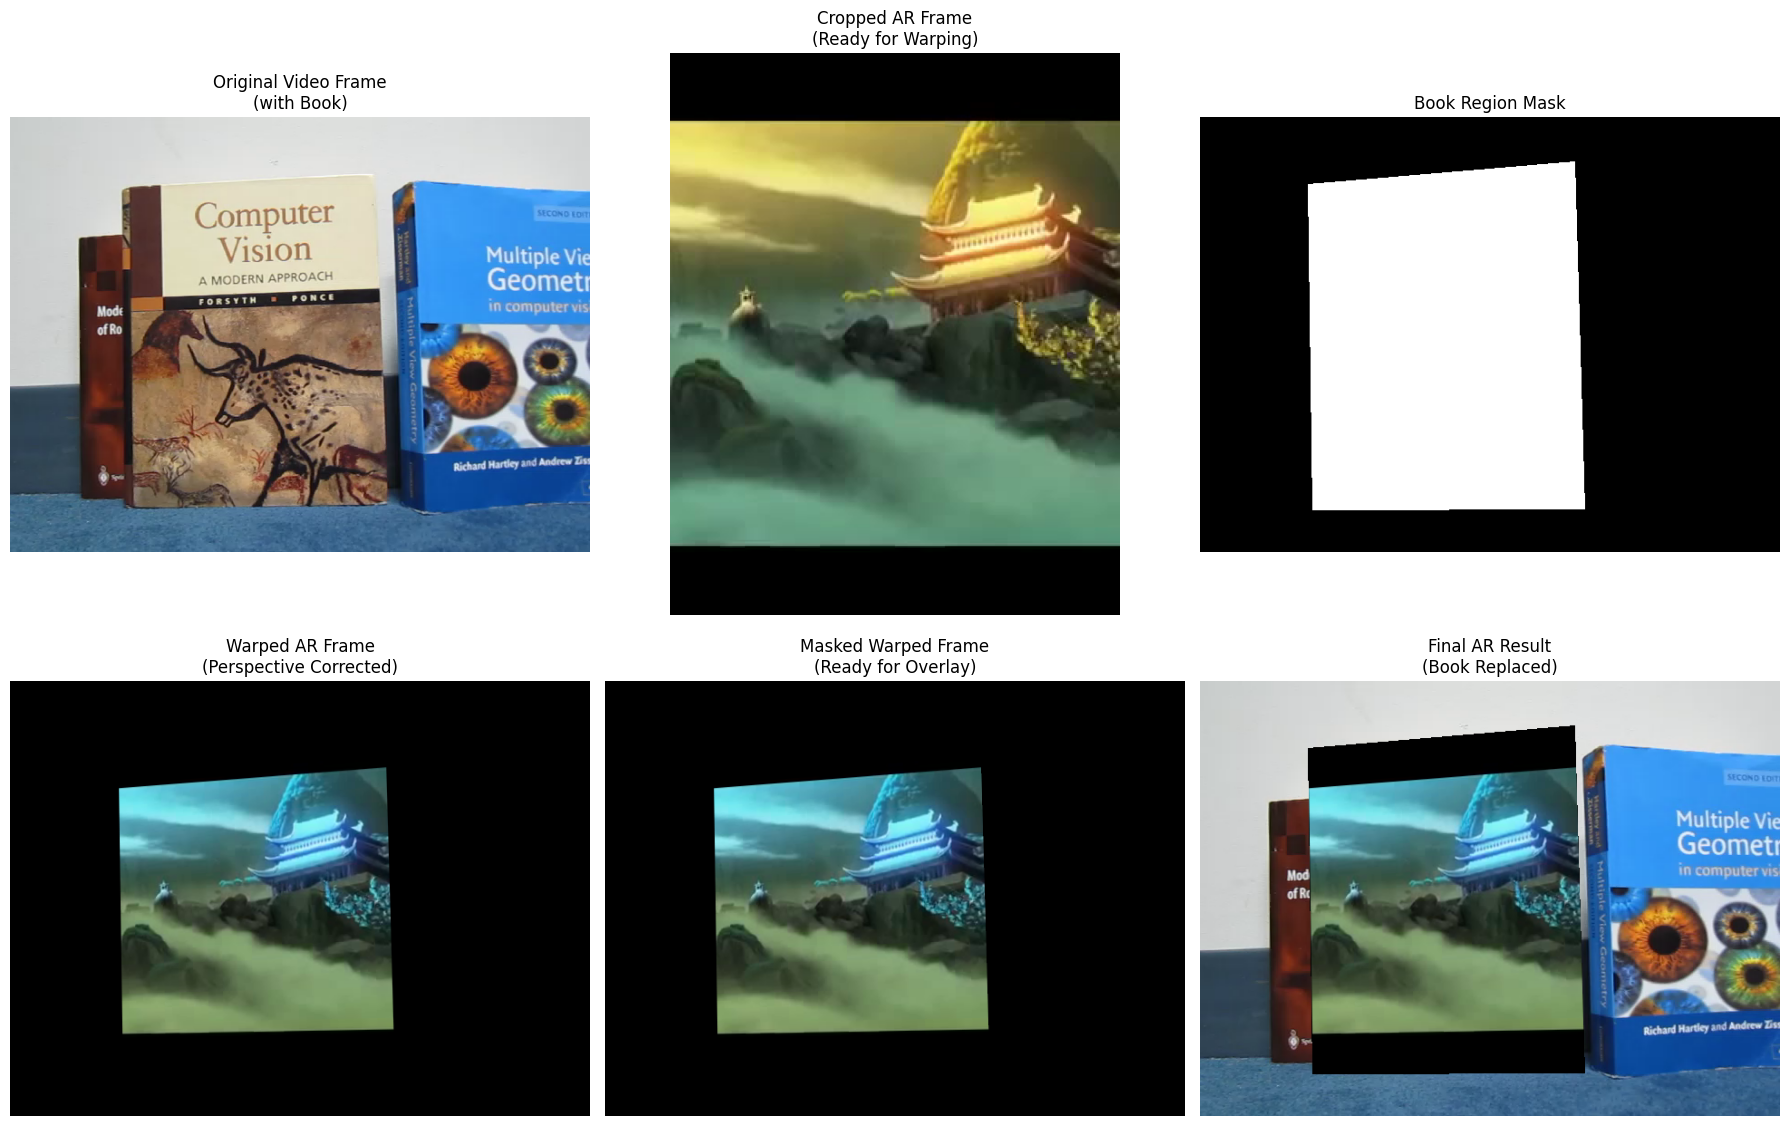

In [25]:
def visualize_ar_process(original_frame, cropped_ar_frame, warped_ar_frame, book_mask, final_result):
    """
    Visualize the entire AR overlay process
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Inputs
    axes[0, 0].imshow(original_frame)
    axes[0, 0].set_title('Original Video Frame\n(with Book)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(cv2.cvtColor(cropped_ar_frame, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title('Cropped AR Frame\n(Ready for Warping)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(book_mask, cmap='gray')
    axes[0, 2].set_title('Book Region Mask')
    axes[0, 2].axis('off')
    
    # Row 2: Processing and Result
    axes[1, 0].imshow(warped_ar_frame)
    axes[1, 0].set_title('Warped AR Frame\n(Perspective Corrected)')
    axes[1, 0].axis('off')
    
    # Show masked warped frame
    masked_warped = cv2.bitwise_and(warped_ar_frame, warped_ar_frame, mask=book_mask)
    axes[1, 1].imshow(masked_warped)
    axes[1, 1].set_title('Masked Warped Frame\n(Ready for Overlay)')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(final_result)
    axes[1, 2].set_title('Final AR Result\n(Book Replaced)')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the complete AR process
visualize_ar_process(video_frame, first_cropped_ar_frame, warped_ar_frame, book_mask, ar_result)

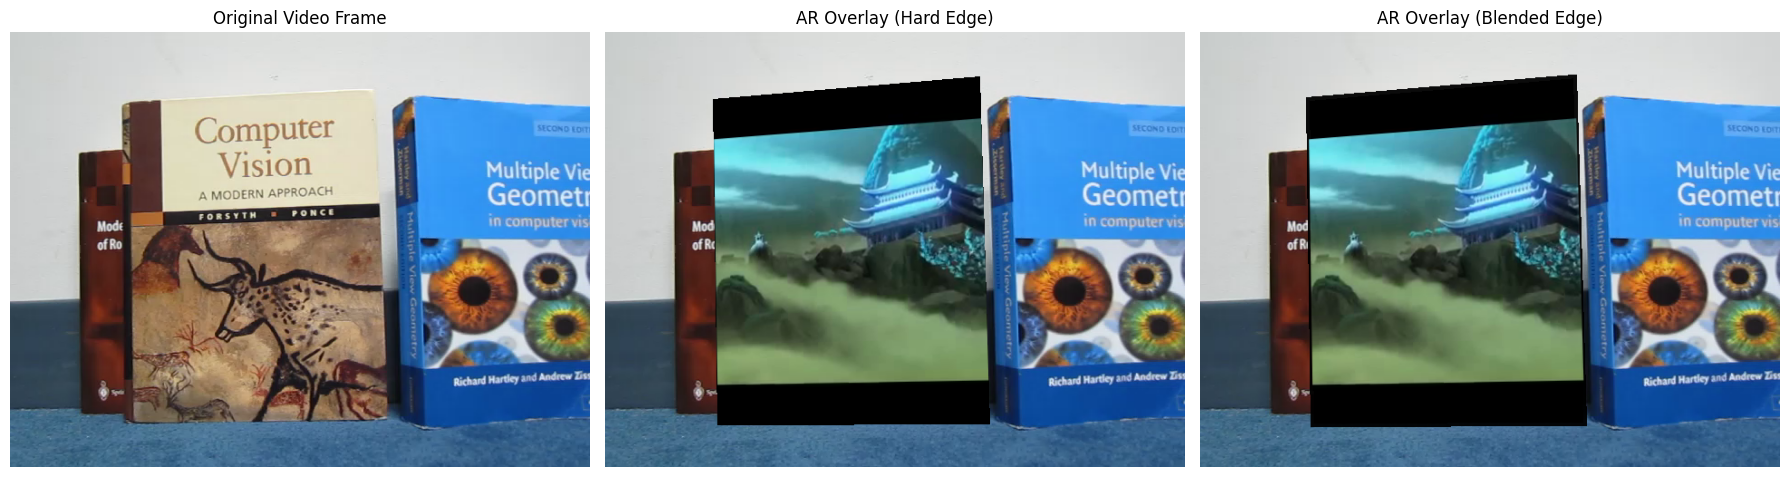

In [26]:
def overlay_ar_with_blending(video_frame, warped_ar_frame, book_mask, alpha=0.95):
    """
    Overlay with edge blending for smoother transitions
    """
    # Create blended mask with smooth edges
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(book_mask, kernel, iterations=1)
    eroded_mask = cv2.erode(book_mask, kernel, iterations=1)
    
    # Create blend region (edges)
    blend_region = cv2.bitwise_xor(dilated_mask, eroded_mask)
    
    # Solid region (inside book)
    solid_region = cv2.bitwise_and(book_mask, cv2.bitwise_not(blend_region))
    
    # Apply solid overlay
    inverse_solid = cv2.bitwise_not(solid_region)
    background = cv2.bitwise_and(video_frame, video_frame, mask=inverse_solid)
    foreground_solid = cv2.bitwise_and(warped_ar_frame, warped_ar_frame, mask=solid_region)
    result = cv2.add(background, foreground_solid)
    
    # Apply blending on edges
    blend_mask = blend_region.astype(float) / 255.0
    
    for c in range(3):  # For each color channel
        result[:, :, c] = (
            result[:, :, c] * (1 - blend_mask) + 
            warped_ar_frame[:, :, c] * blend_mask * alpha +
            video_frame[:, :, c] * blend_mask * (1 - alpha)
        )
    
    return result.astype(np.uint8)

# Try blended overlay
ar_result_blended = overlay_ar_with_blending(video_frame, warped_ar_frame, book_mask)

# Compare both methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(video_frame)
axes[0].set_title('Original Video Frame')
axes[0].axis('off')

axes[1].imshow(ar_result)
axes[1].set_title('AR Overlay (Hard Edge)')
axes[1].axis('off')

axes[2].imshow(ar_result_blended)
axes[2].set_title('AR Overlay (Blended Edge)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Create Overlayed Video

In [27]:
def track_book_frame_to_frame(book_video_path, initial_book_corners, cropped_ar_frames, max_frames=None):
    """
    Track book using homography between consecutive frames
    """
    cap = cv2.VideoCapture(book_video_path)
    ar_results = []
    book_corners_history = [initial_book_corners.copy()]
    previous_frame = None
    current_corners = initial_book_corners.copy()
    
    frame_count = 0
    while True:
        ret, current_frame = cap.read()
        if not ret:
            break
            
        if max_frames and frame_count >= max_frames:
            break
        
        # Convert to RGB for processing
        current_frame_rgb = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
        
        if frame_count == 0:
            # First frame - use initial corners
            warped_ar = warp_frame_to_book(cropped_ar_frames[frame_count % len(cropped_ar_frames)], current_corners)[0]
            book_mask = create_book_mask(current_frame_rgb.shape, current_corners)
            ar_result = overlay_ar_with_blending(current_frame_rgb, warped_ar, book_mask)
            previous_frame = current_frame_rgb
        else:
            try:
                # Compute homography between previous and current frame
                H_frame, _ = compute_frame_homography(previous_frame, current_frame_rgb, current_corners)
                
                if H_frame is not None:
                    # Update book corners
                    current_corners = apply_homography_to_corners(current_corners, H_frame)
                    book_corners_history.append(current_corners.copy())
                    
                    # Overlay AR content
                    ar_frame_idx = frame_count % len(cropped_ar_frames)
                    warped_ar = warp_frame_to_book(cropped_ar_frames[ar_frame_idx], current_corners)[0]
                    book_mask = create_book_mask(current_frame_rgb.shape, current_corners)
                    ar_result = overlay_ar_with_blending(current_frame_rgb, warped_ar, book_mask)
                else:
                    # Fallback: use previous corners
                    ar_frame_idx = frame_count % len(cropped_ar_frames)
                    warped_ar = warp_frame_to_book(cropped_ar_frames[ar_frame_idx], current_corners)[0]
                    book_mask = create_book_mask(current_frame_rgb.shape, current_corners)
                    ar_result = overlay_ar_with_blending(current_frame_rgb, warped_ar, book_mask)
                    
            except Exception as e:
                print(f"Error in frame {frame_count}: {e}")
                # Fallback to previous corners
                ar_frame_idx = frame_count % len(cropped_ar_frames)
                warped_ar = warp_frame_to_book(cropped_ar_frames[ar_frame_idx], current_corners)[0]
                book_mask = create_book_mask(current_frame_rgb.shape, current_corners)
                ar_result = overlay_ar_with_blending(current_frame_rgb, warped_ar, book_mask)
        
        ar_results.append(ar_result)
        previous_frame = current_frame_rgb
        frame_count += 1
        
        if frame_count % 30 == 0:
            print(f"Processed {frame_count} frames...")
    
    cap.release()
    print(f"Completed frame-to-frame tracking: {len(ar_results)} frames")
    return ar_results, book_corners_history

def compute_frame_homography(prev_frame, curr_frame, previous_corners):
    """
    Compute homography between two consecutive frames using feature matching
    """
    # Use SIFT to find features in both frames
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(prev_frame, None)
    kp2, des2 = sift.detectAndCompute(curr_frame, None)
    
    if des1 is None or des2 is None:
        return None, None
    
    # Match features
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    if len(good_matches) < 10:
        return None, None
    
    # Extract points
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])
    
    # Compute homography with RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    return H, good_matches

def apply_homography_to_corners(corners, H):
    """
    Apply homography to transform corners
    """
    corners_reshaped = corners.reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners_reshaped, H)
    return transformed_corners.reshape(-1, 2)

In [28]:
def track_book_to_frame(book_video_path, book_img, cropped_ar_frames, max_frames=None):
    """
    Track book by computing homography between book image and each frame
    """
    cap = cv2.VideoCapture(book_video_path)
    ar_results = []
    book_corners_history = []
    
    # Initialize SIFT for book detection
    sift = cv2.SIFT_create()
    kp_book, des_book = sift.detectAndCompute(book_img, None)
    
    frame_count = 0
    ar_frame_idx = 0  # Track AR video frame separately
    
    while True:
        ret, current_frame = cap.read()
        if not ret:
            break
            
        if max_frames and frame_count >= max_frames:
            break
        
        current_frame_rgb = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
        
        try:
            # Detect book in current frame
            book_corners = detect_book_in_frame(current_frame_rgb, kp_book, des_book, book_img.shape)
            
            if book_corners is not None:
                # Use the current AR frame and advance to next one
                if ar_frame_idx < len(cropped_ar_frames):
                    warped_ar = warp_frame_to_book(cropped_ar_frames[ar_frame_idx], book_corners)[0]
                    book_mask = create_book_mask(current_frame_rgb.shape, book_corners)
                    # ar_result = overlay_ar_with_blending(current_frame_rgb, warped_ar, book_mask)
                    ar_result = overlay_ar_on_book(current_frame_rgb, warped_ar, book_mask)
                    book_corners_history.append(book_corners)
                    
                    # Only advance AR frame if we successfully used it
                    ar_frame_idx += 1
                else:
                    # AR video finished, just show book frame
                    ar_result = current_frame_rgb
                    book_corners_history.append(book_corners)
            else:
                # Fallback: skip frame or use previous detection
                if frame_count > 0 and len(book_corners_history) > 0:
                    book_corners = book_corners_history[-1]
                    if ar_frame_idx < len(cropped_ar_frames):
                        warped_ar = warp_frame_to_book(cropped_ar_frames[ar_frame_idx], book_corners)[0]
                        book_mask = create_book_mask(current_frame_rgb.shape, book_corners)
                        ar_result = overlay_ar_with_blending(current_frame_rgb, warped_ar, book_mask)
                        book_corners_history.append(book_corners)
                        
                        # Only advance AR frame if we successfully used it
                        ar_frame_idx += 1
                    else:
                        ar_result = current_frame_rgb
                        book_corners_history.append(book_corners)
                else:
                    # No book detected, use original frame
                    ar_result = current_frame_rgb
                    book_corners_history.append(None)
                    
        except Exception as e:
            print(f"Error in frame {frame_count}: {e}")
            ar_result = current_frame_rgb
            book_corners_history.append(None)
        
        ar_results.append(ar_result)
        frame_count += 1
        
        if frame_count % 10 == 0:
            print(f"Processed {frame_count} frames, AR frame: {ar_frame_idx}/{len(cropped_ar_frames)}")
    
    cap.release()
    print(f"Completed book-to-frame tracking: {len(ar_results)} frames")
    print(f"AR video frames used: {ar_frame_idx}/{len(cropped_ar_frames)}")
    return ar_results, book_corners_history

def detect_book_in_frame(frame, kp_book, des_book, book_shape):
    """
    Detect book in frame using feature matching
    """
    sift = cv2.SIFT_create()
    kp_frame, des_frame = sift.detectAndCompute(frame, None)
    
    if des_frame is None:
        return None
    
    # Match features
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_book, des_frame, k=2)
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    if len(good_matches) < 10:
        return None
    
    # Extract points
    src_pts = np.float32([kp_book[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in good_matches])
    
    # Compute homography
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    if H is None:
        return None
    
    # Transform book corners
    h, w = book_shape[:2]
    corners_src = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    corners_dst = cv2.perspectiveTransform(corners_src, H)
    
    return corners_dst.reshape(-1, 2)

In [29]:
def create_ar_video(ar_frames, output_path, fps=30):
    """
    Create video from AR frames
    """
    if len(ar_frames) == 0:
        raise ValueError("No AR frames to create video")
    
    # Get frame dimensions
    height, width = ar_frames[0].shape[:2]
    
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    print(f"Creating AR video: {width}x{height}, {fps} FPS")
    
    for i, frame in enumerate(ar_frames):
        # Convert back to BGR for video writing
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
        
        if (i + 1) % 30 == 0:
            print(f"Written {i + 1} frames...")
    
    out.release()
    print(f"✅ AR video saved: {output_path}")

def preview_ar_frames(ar_frames, num_frames=6):
    """
    Preview sample frames from the AR video
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    # Select frames to preview
    step = max(1, len(ar_frames) // num_frames)
    preview_indices = [i * step for i in range(min(num_frames, len(ar_frames)))]
    
    for i, idx in enumerate(preview_indices):
        if idx < len(ar_frames):
            axes[i].imshow(ar_frames[idx])
            axes[i].set_title(f'Frame {idx}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

Processed 30 frames...
Processed 60 frames...
Processed 90 frames...
Processed 120 frames...
Processed 150 frames...
Processed 180 frames...
Processed 210 frames...
Processed 240 frames...
Processed 270 frames...
Processed 300 frames...
Processed 330 frames...
Processed 360 frames...
Processed 390 frames...
Processed 420 frames...
Processed 450 frames...
Processed 480 frames...
Processed 510 frames...
Finished cropping 511 frames
Processed 10 frames, AR frame: 10/511
Processed 20 frames, AR frame: 20/511
Processed 30 frames, AR frame: 30/511
Processed 40 frames, AR frame: 40/511
Processed 50 frames, AR frame: 50/511
Processed 60 frames, AR frame: 60/511
Processed 70 frames, AR frame: 70/511
Processed 80 frames, AR frame: 80/511
Processed 90 frames, AR frame: 90/511
Processed 100 frames, AR frame: 100/511
Processed 110 frames, AR frame: 110/511
Processed 120 frames, AR frame: 120/511
Processed 130 frames, AR frame: 130/511
Processed 140 frames, AR frame: 140/511
Processed 150 frames, AR

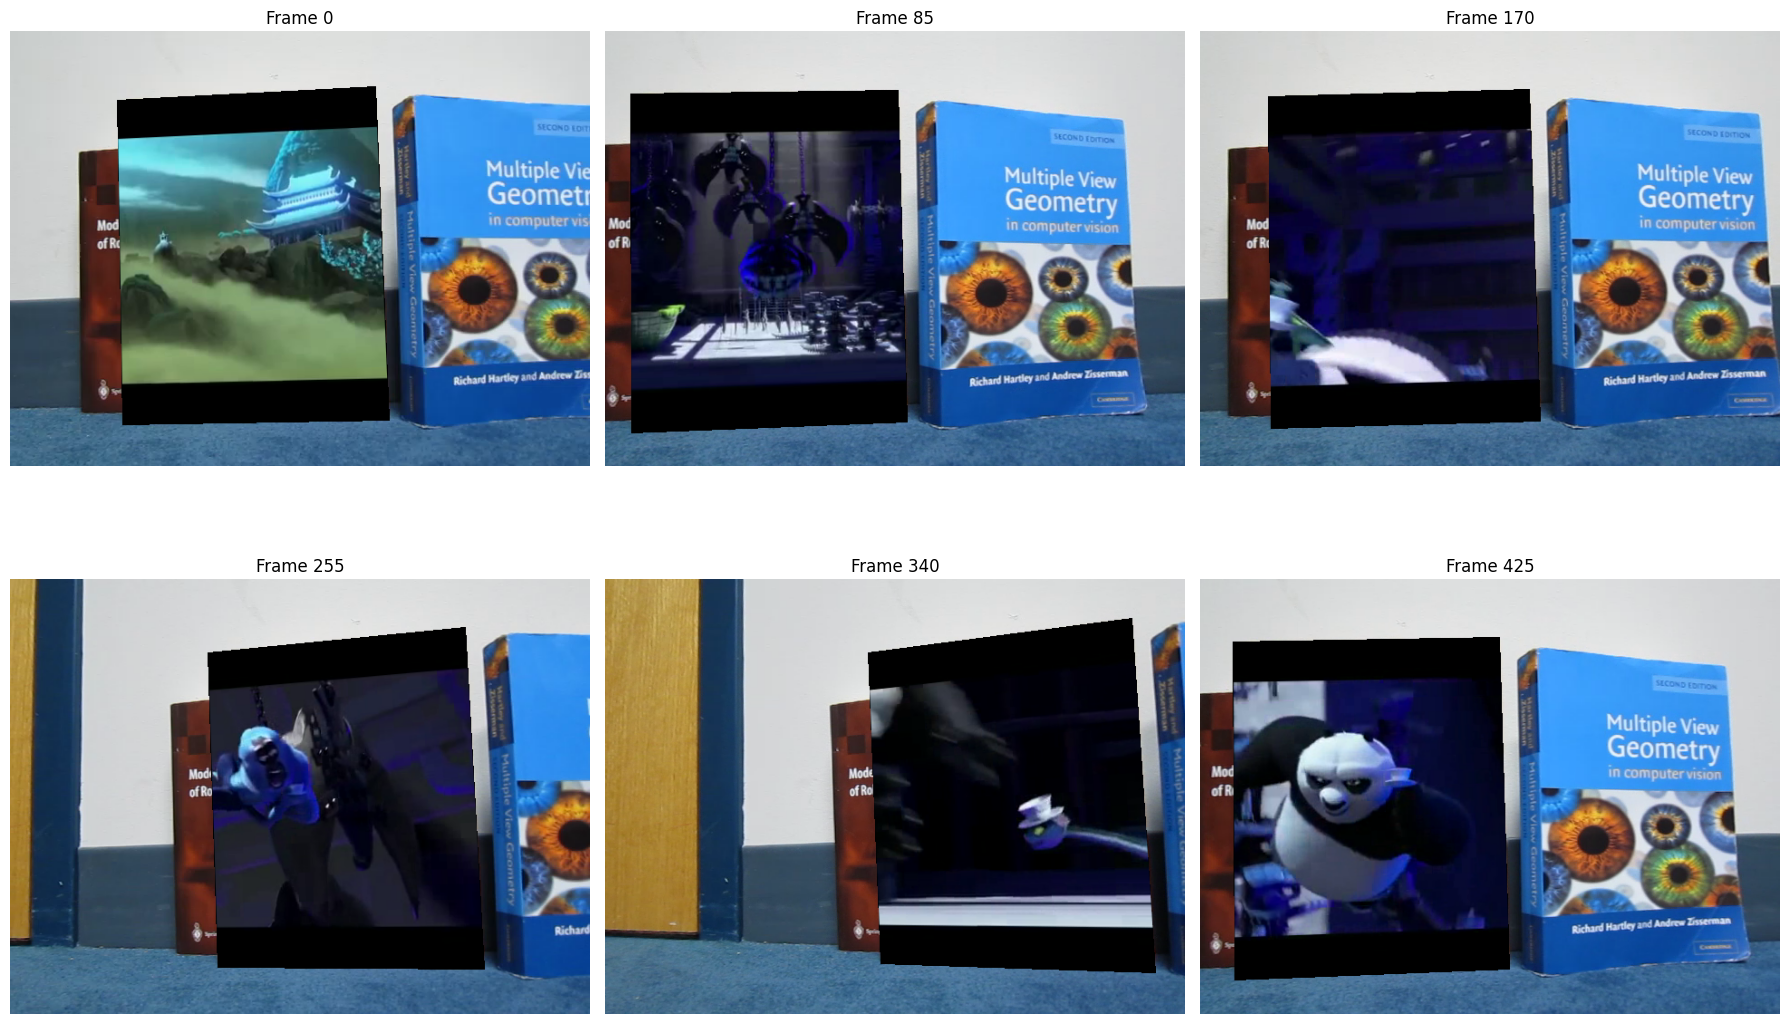

Creating final AR video: /kaggle/working/ar_final_output.mp4
Creating AR video: 640x480, 30 FPS
Written 30 frames...
Written 60 frames...
Written 90 frames...
Written 120 frames...
Written 150 frames...
Written 180 frames...
Written 210 frames...
Written 240 frames...
Written 270 frames...
Written 300 frames...
Written 330 frames...
Written 360 frames...
Written 390 frames...
Written 420 frames...
Written 450 frames...
Written 480 frames...
Written 510 frames...
✅ AR video saved: /kaggle/working/ar_final_output.mp4


In [30]:
total_frames = ar_video_info['total_frames']
cropped_ar_frames = crop_video_frames('/kaggle/input/asg-2-1-data/ar_source.mov', crop_region, total_frames)

book_video_path = '/kaggle/input/asg-2-1-data/book.mov'
ar_frames, corners_history = track_book_to_frame(
        book_video_path, book_img, cropped_ar_frames, total_frames
    )

print("Previewing AR frames...")
preview_ar_frames(ar_frames)
        
# 3. Create final video
output_path = "/kaggle/working/ar_final_output.mp4"
print(f"Creating final AR video: {output_path}")
create_ar_video(ar_frames, output_path, fps=30)